In [13]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from PIL.ImagePath import Path
from tabulate import tabulate
import warnings

from utils.utilities import masks_as_image, multi_rle_encode, masks_as_color, rle_encode
from utils.utilities import multi_masks
from utils.utilities import show_img
warnings.filterwarnings("ignore")
%matplotlib inline

In [19]:
PATH = r'D:\DATA\Airbus Ship Detection Challenge\airbus-ship-detection'
TRAIN = r'D:\DATA\Airbus Ship Detection Challenge\airbus-ship-detection\data\images\train'
TEST = r'D:\DATA\Airbus Ship Detection Challenge\airbus-ship-detection\data\images\test'
SEGMENTATION = r'D:\DATA\Airbus Ship Detection Challenge\airbus-ship-detection\data\train_ship_segmentations_v2.csv'
TRAIN_DN = 'train'
MASKS_DN = 'masks'

In [20]:
train_names = [f for f in os.listdir(TRAIN)]
test_names = [f for f in os.listdir(TEST)]

In [21]:
seg_df = pd.read_csv(SEGMENTATION)
seg_df

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


In [22]:
print(f'Length of train dataset is: {len(train_names)}')
print(f'Length of test dataset is: {len(test_names)}')

Length of train dataset is: 192556
Length of test dataset is: 15606


In [23]:
not_empty = pd.notna(seg_df.EncodedPixels)
not_empty.sum(), seg_df[not_empty].ImageId.nunique()
print(f'{len(train_names)} images total.\n '
      f'{seg_df[not_empty].ImageId.nunique()}'
      f' images contain ships with a total of \n{not_empty.sum()} distinct ship masks.')

192556 images total.
 42556 images contain ships with a total of 
81723 distinct ship masks.


In [24]:
rle_0 = seg_df.query('ImageId=="00a52cd2a.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
# np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(threshold=1000)
img_0

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=int16)

Check Decoding->Encoding RLE_0: 1 -> RLE_1: 1
0 error


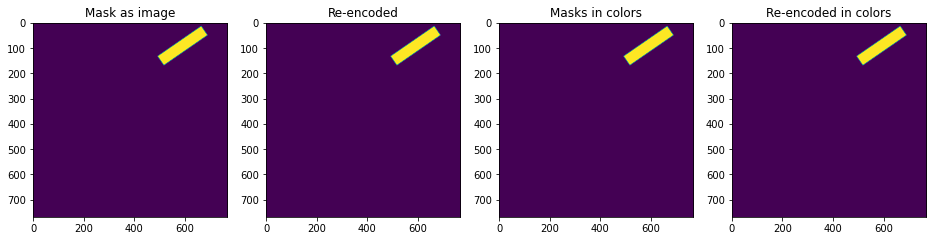

In [25]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (16, 5))
plt.rcParams['figure.facecolor'] = 'white'
rle_0 = seg_df.query('ImageId=="00a52cd2a.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0)
ax1.set_title('Mask as image')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1)
ax2.set_title('Re-encoded')
img_c = masks_as_color(rle_0)
ax3.imshow(img_c)
ax3.set_title('Masks in colors')
img_c = masks_as_color(rle_1)
ax4.imshow(img_c)
ax4.set_title('Re-encoded in colors')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))
print(np.sum(img_0 - img_1), 'error')

In [26]:
seg_df['ships'] = seg_df['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
seg_df.head(5)

,ImageId,EncodedPixels,ships
0,00003e153.jpg,NaN,0
1,0001124c7.jpg,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1


In [27]:
unique_img_ids = seg_df.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids

,ImageId,ships,has_ship
0,00003e153.jpg,0,0.0
1,0001124c7.jpg,0,0.0
2,000155de5.jpg,1,1.0
3,000194a2d.jpg,5,1.0
4,0001b1832.jpg,0,0.0
...,...,...,...
192551,fffedbb6b.jpg,0,0.0
192552,ffff2aa57.jpg,0,0.0
192553,ffff6e525.jpg,0,0.0
192554,ffffc50b4.jpg,0,0.0


In [29]:
ship_files = unique_img_ids[unique_img_ids.has_ship>0].ImageId.values
empty_files = unique_img_ids[unique_img_ids.has_ship==0].ImageId.values

In [30]:
print(f'With ships:    {len(ship_files)}\n'
      f'Without ships:    {len(empty_files)}')
print(f'Proportion:    {ship_files.shape[0] / empty_files.shape[0]}')
print('Ration with ships:     ' +str(round((ship_files.shape[0]/len(train_names)),2)))
print('Ration without ships:  ' +str(round((empty_files.shape[0]/len(train_names)),2)))

With ships:    42556
Without ships:    150000
Proportion:    0.28370666666666666
Ration with ships:     0.22
Ration without ships:  0.78


In [31]:
seg_df[seg_df.ImageId.isin(ship_files)].head()

,ImageId,EncodedPixels,ships
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,1
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...,1


In [32]:
samp_df = seg_df[seg_df.ImageId.isin(ship_files)].copy()

In [33]:
samp_df.reset_index(inplace=True)

In [34]:
samp_unique = unique_img_ids[unique_img_ids.ImageId.isin(ship_files)]
samp_unique.head(5)

,ImageId,ships,has_ship
2,000155de5.jpg,1,1.0
3,000194a2d.jpg,5,1.0
5,00021ddc3.jpg,9,1.0
6,0002756f7.jpg,2,1.0
9,00031f145.jpg,1,1.0


In [35]:
counts = samp_unique['ships'].value_counts(sort=False)
results = [(i, counts[i]) for i in range(1,16)]
print(tabulate(results, headers=['number of ships','number of images'], tablefmt='presto'))


   number of ships |   number of images
-------------------+--------------------
                 1 |              27104
                 2 |               7674
                 3 |               2954
                 4 |               1622
                 5 |                925
                 6 |                657
                 7 |                406
                 8 |                318
                 9 |                243
                10 |                168
                11 |                144
                12 |                124
                13 |                 75
                14 |                 76
                15 |                 66


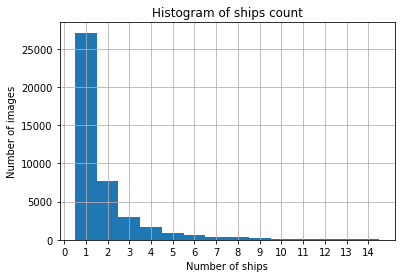

In [36]:
hist = samp_unique['ships'].hist(bins=np.arange(samp_unique['ships'].max())+0.5)
plt.xticks(range(15))
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.title("Histogram of ships count")
plt.xlabel("Number of ships")
plt.ylabel("Number of images")
plt.show(hist)

In [37]:
enc_group = samp_df.groupby('ImageId')
image_fns = samp_unique.ImageId.values


In [323]:
%time
multi_masks(image_fns, enc_group)

Wall time: 0 ns


In [38]:
mask_files = os.listdir(PATH+'/masks')
print(f'{len(mask_files)} masks file was created')

42556 masks file was created


In [41]:
ims = [Image.open(PATH+'/masks/'+mask_files[i]) for i in range(16)]
mask_to_ship = [i.split('_')[0] + '.jpg' for i in mask_files]
ship_ims = [Image.open(TRAIN+'/'+mask_to_ship[i]) for i in range(16)]

In [42]:
def plot_images(im, mask = False):
      fig, axes = plt.subplots(4, 4, figsize=(12, 9))
      for i, ax in enumerate(axes.flat):
          ax = show_img(im[i], ax=ax)
          if mask:
            show_img(ims[i], ax=ax, alpha=0.5)

      plt.tight_layout(pad=0.1)

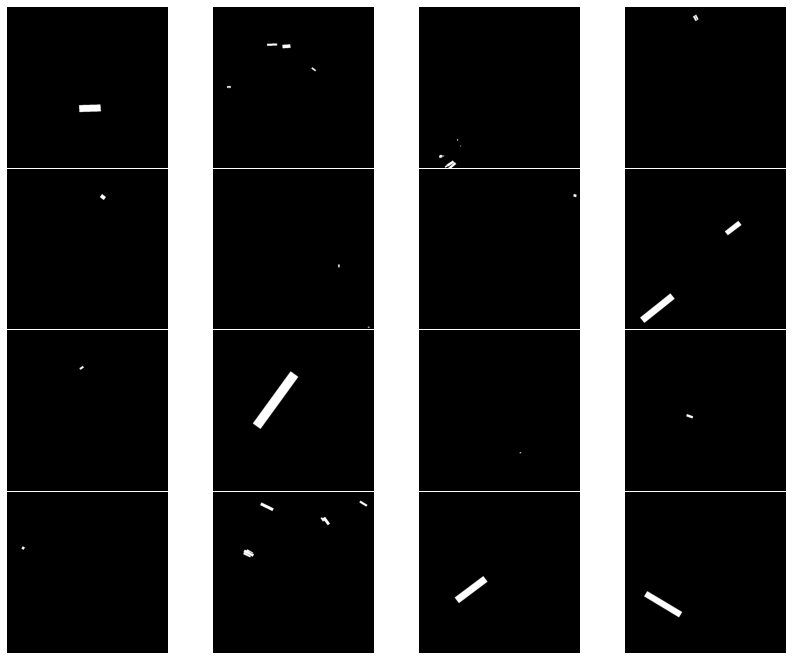

In [43]:
plot_images(ims)

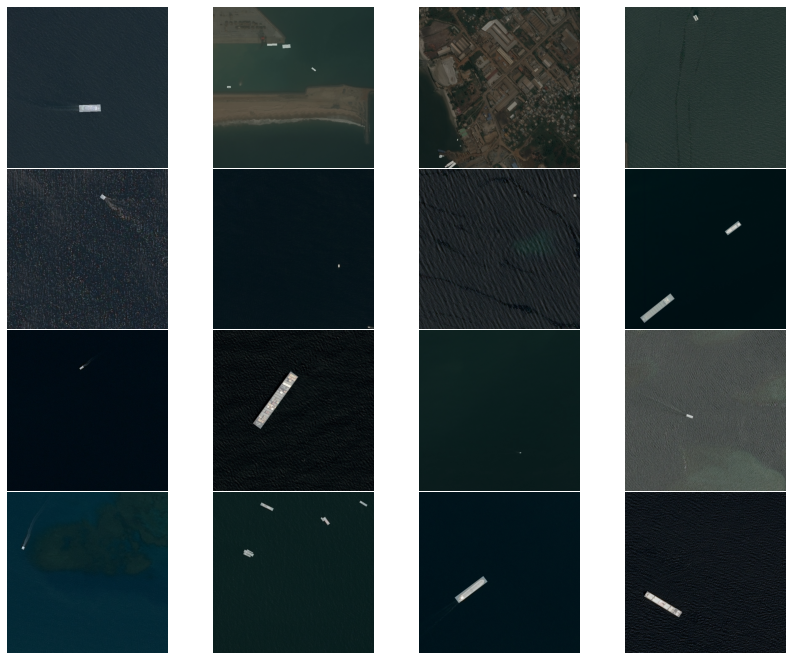

In [44]:
plot_images(ship_ims, mask=True)

In [45]:
def rle_pixel_count(rle):
    count = 0
    if not pd.isna(rle):
        rle_split = rle.split()
        for value in rle_split[1::2]:
            count += int(value)
    return count


seg_df['PixelCount'] = seg_df['EncodedPixels'].apply(rle_pixel_count)
total_ship_pixels = sum(seg_df['PixelCount'])
total_pixels = 768 * 768 * len(train_names)
print("Percentage of ship-pixels total: {0:.3f}%".format((total_ship_pixels / total_pixels)  * 100))
total_pixels = 768 * 768 * seg_df[not_empty].ImageId.nunique()
print("Percentage of ship-pixels with ships: {0:.3f}%".format((total_ship_pixels / total_pixels) * 100))

Percentage of ship-pixels total: 0.113%
Percentage of ship-pixels with ships: 0.510%


In [46]:
ship_df = seg_df.loc[seg_df['PixelCount'] > 0].copy()
print("Number of ships:", ship_df['PixelCount'].count())
print("Mean ship size in pixels:", ship_df['PixelCount'].mean())
print("Maximum ship size in pixels:", ship_df['PixelCount'].max())
print("Minimum ship size in pixels:", ship_df['PixelCount'].min())


Number of ships: 81723
Mean ship size in pixels: 1567.4028486472596
Maximum ship size in pixels: 25904
Minimum ship size in pixels: 2


In [47]:
min_size = 18
print("Number of ships with less than {} pixels: {}".format(
    min_size, len(ship_df.loc[ship_df['PixelCount'] < min_size])))

Number of ships with less than 18 pixels: 731
